<center><font size="6"><b>Detection of Knee Osteoarthritis from X-Ray Images:<font color='magenta'> Exploratory Data Analysis</b></font></font></center>

<h2><center><a href="https://www.linkedin.com/in/sonjoydas/"><font color='blue'>Sonjoy Das, PhD</font></a></center></h2>


This work on image classification of Knee Osteoarthritis conditions will loosely follow Tensorflow's Advanced tutorial on [Image Classificatiton](https://www.tensorflow.org/tutorials/images/classification).

This is the **second notebook** of this project. This notebook particularly contains the steps related to **Exploratory Data Analysis** (EDA) and the necessary explanations. The **previous steps**, that have already been carried out, are included in the appropriate notebooks as indicated below:

+ **(first notebook)**. Data Wrangling (file: 2_DataWrangling.ipynb)
+ **(this notebook)**. Exploratory Data Analysis


In the EDA step, we will try to find out some meaningful information about the images through a few standard and advanced operations on the images. We will primarily follow two articles ([article1](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2) and [article2](https://nicholastsmith.wordpress.com/2016/02/18/eigenfaces-versus-fisherfaces-on-the-faces94-database-with-scikit-learn/)).

## 2.1 Imports<a id='1.1_Imports'></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To create colorbar in subplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
%matplotlib inline

from mpl_toolkits import mplot3d

from scipy.stats import entropy

from sklearn.decomposition import PCA

from skimage import filters

# To restore some data results from previous stage and save some other data
import pickle

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import manifold

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import ComplementNB
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

2022-11-26 00:38:39.931325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from platform import python_version
python_version()

'3.10.4'

## 2.2 Load Data from Data Wrangling Step

In [3]:
# Source: https://stackoverflow.com/questions/6568007/how-do-i-save-and-restore-multiple-variables-in-python

# combined_folder_path, KL_grading, all_class_names, image_size, and channel
# are restored here...

# Getting back the objects:
with open('2_DataWrangling.pkl', 'rb') as f:
    combined_folder_path, KL_grading, all_class_names, image_size, channel, black, white = pickle.load(f)

print(f"combined_folder_path: {combined_folder_path}\n")
print(f"KL_grading: {KL_grading}\n")
print(f"all_class_names: {all_class_names}\n")
print(f"image size: {image_size}\n")
print(f"# of channel: {channel}\n")
print(f"(black value, white value): ({black}, {white})")

combined_folder_path: KneeXrayImages/temp/

KL_grading: ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

all_class_names: ['0', '1', '2', '3', '4']

image size: (224, 224)

# of channel: 1

(black value, white value): (0, 255)


## 2.3 Visualize the Data: Raw Comparision

First, let us  start by simply plotting a few randomly sampled images. In choosing random samples, it is important to reproduce the *same* results everytime we run our code. Here, we will use `Generator` (Ref: [numpy.random.Generator(bit_generator)](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator)) and `PCG64` to generate our random samples. We will follow the [example](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.Generator:~:text=to%20choose%20from.-,Examples,-%3E%3E%3E%20from%20numpy) given there.

We will use `.choice` (Ref: [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)) to generate our random samples and pass a `seed` [this is different from using `np.random.seed()`] value to `np.random.Generator(np.random.PCG64())` to reproduce our results.

In [4]:
print(f"Folder path of all images: {combined_folder_path}")

# Get the list of .png from sub image class folders - 
# Here folder '0' represents normal knee condition whereas folder '4' 
# represents severly affected knee condition
image_files = []
for i in range(len(all_class_names)):
    subfolder_path = combined_folder_path + all_class_names[i]
    image_files.append([fn for fn in os.listdir(f"{subfolder_path}") if fn.endswith('.png')])


    
print(f"The numpy version:{np.__version__}")
rng = np.random.Generator(np.random.PCG64(seed = 54321))
print(rng)


# Randomly select 4 of each class of images
n_image = 4

random_images_list = []

for i in range(len(all_class_names)):
    random_images_list.append(rng.choice(image_files[i], n_image, replace = False))
    
    if i == 0:
        print(f"\nNormal image files:\n")
    elif i == 1:
        print(f"\nDoubtful image files:\n")
    elif i == 2:
        print(f"\nMild image files:\n")
    elif i == 3:
        print(f"\nModerate image files:\n")
    elif i == 4:
        print(f"\nSevere image files:\n")
    
    print(f"\t{random_images_list[i]}")

Folder path of all images: KneeXrayImages/temp/
The numpy version:1.22.3
Generator(PCG64)

Normal image files:

	['9670198_2.png' '9187595L.png' '9452628L.png' '9460076_2.png']

Doubtful image files:

	['9244516R.png' '9555397_2.png' '9150876R.png' '9698980_2.png']

Mild image files:

	['9646610L.png' '9138554L.png' '9330729L.png' '9451546_1.png']

Moderate image files:

	['9880069L.png' '9161267_2.png' '9526396R.png' '9886598R.png']

Severe image files:

	['9938636R.png' '9637958R.png' '9410340R.png' '9645683L.png']


Now by plotting these images, we can visualize how the x-ray images change from '**Normal**' to '**Severe**' conditions. For the plotting purpose, we will scale the image values between `(vmin, vmax) = (black, white) = (0, 255)`.

# of Normal images: 3857

# of Doubtful images: 1770

# of Mild images: 2578

# of Moderate images: 1286

# of Severe images: 295



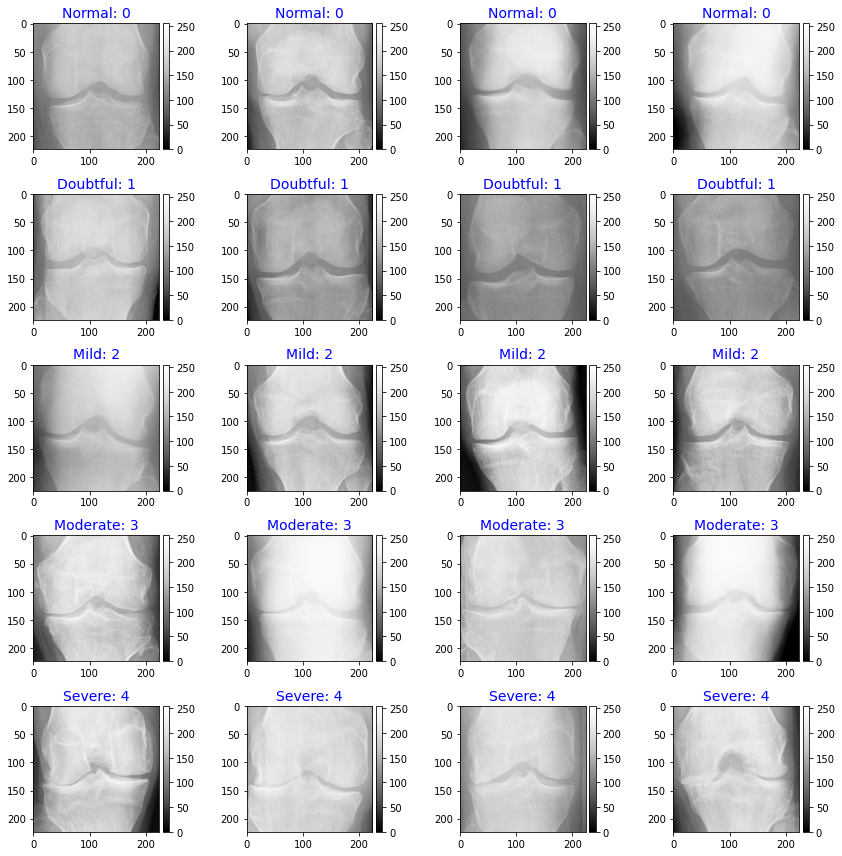

In [5]:
# Plotting len(all_class_names) x n_image image matrix
# Here, len(all_class_names) = 5, and n_image = 4

if channel == 1:
    color_mode = "grayscale"
elif channel == 3:
    color_mode = "rgb"
elif channel == 4:
    color_mode = "rgba"
        
plt.figure(figsize = (12,12))

subplot_index = 0
for i in range(len(all_class_names)):
    
    plt_label = KL_grading[i]+': '+all_class_names[i]
    
    for j in range(n_image):
        
        subplot_index += 1
    
        image_path = f'{combined_folder_path}{all_class_names[i]}/{random_images_list[i][j]}'
    
        ax = plt.subplot(len(all_class_names), n_image, subplot_index)
    
        # https://www.tensorflow.org/api_docs/python/tf/keras/utils/load_img
        # https://stackoverflow.com/questions/384759/how-do-i-convert-a-pil-image-into-a-numpy-array
        image = tf.keras.preprocessing.image.load_img(image_path,
                                                  color_mode=color_mode,
                                                  interpolation="bilinear")
        imgplot  = ax.imshow(image, vmin = black, vmax = white, cmap='Greys_r')
        ax.set_title(plt_label,color='blue', fontsize=14)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)
    
    # Also check the number of files here to make sure they are same as Data Wrangling step
    print(f"# of {KL_grading[i]} images: {len(image_files[i])}\n")
    
plt.tight_layout()
plt.show()

It is clear that the articular cartilage (the "gap") between two bones in the knee reduces significantly as the KL grading increases from 'Normal' ('0') to 'Severe' ('4') conditions. In the 'Severe' condition, the two bones grind painfully against each other leading to inflammation, swelling and limiting movement of the patients.

## 2.4 Images as Matrix<a id='2.4_Images_as_Matrix'></a>

For the next few steps, we will work directly with the pixel values of each image so that we can do operations on them. We can accomplish this by converting our images into a `numpy` array.

The function `img2np()` below will turn each image into a 1-D vector (or, 2D numpy array) and return it as `img_1D` of size `(1, n_features)`, where `n_features = np.prod(np.shape(img_matrix)) = 224 × 224 = 50176` is the number of pixels of each image (i.e., the number of features) and `img_matrix` is the `numpy.ndarray` representation of an image. The datatype of `img_matrix` can be. loaded as `"uint8"`which is a 8 bit integer and its range value is (0 to 255) [re: [Python NumPy Data types](https://pythonguides.com/python-numpy-data-types/)]. But, we will load it as `"float32"` to preserve the precision of the statistics of the images that we will compute later in this notebok, such as average images in Section 2.5, standard deviation matrix in Section 2.7, etc.

The function `get_n_by_m_matrix()` involving `for` loop with `j` below will iterate through each file in a given class given by `this_class` (i.e., `'0'`, `'1'`, `'2'`, `'3'`, and `'4'`) and collect all the 1-D vectors `img_1D`s to turn them into an (`n_samples`, `n_features`) matrix which is returned as `images_1D_this_class`. Here, `n_samples` is the number of images (i.e., the number of samples) in the given class. In the function *name* of `get_n_by_m_matrix()`, we are denoting `n_samples` as `n` and `n_features` as `m` for simplicity.

The function `collect_all_image_1D()` involving `for` loop with `i` collects all the (`n_samples`, `n_features`) matrices `images_1D_this_class`s for each of the 5 classes and return a list of `images_1D_all_class`. Each element of `images_1D_all_class` is an (`n_samples`, `n_features`) matrix. This is ragged list because `n_samples` varies over different classes (even though `n_features` is same for all images across all classes).

In [6]:
def img2np(image_path,color_mode):
    
    image = tf.keras.preprocessing.image.load_img(image_path,color_mode=color_mode,
                                                  interpolation="bilinear")
    # Covert image to a numpy.ndarray
    img_matrix = tf.keras.preprocessing.image.img_to_array(image, dtype = "float32")
    
    # Turn that into a 1-D vector, i.e., into a 2D numpy array of
    # shape (1, np.prod(np.shape(img_matrix))).
    # If you do not use reshape(1,-1), then it will be a 1D numpy array of
    # shape (np.prod(np.shape(img_matrix)), ), which we will not be able
    # to arrange in a 2D numpy array when collecting the 1-D vectors of all images.
    img_1D = img_matrix.ravel().reshape(1,-1)
    
    return img_1D


def get_n_by_m_matrix(image_folders_path,this_class,list_of_filename,color_mode):

    # Run img2np(image_path) function for each image file of a class 
    # through this loop to get an (n, m) matrix, where n is the number of 
    # images (number of samples) in a class and m = np.prod(np.shape(img_matrix)) 
    # is the number of pixels of images for this class (number of features). 
    # Here, m is same for each image.

    for j in range(len(list_of_filename)):
        image_path = f'{image_folders_path}{this_class}/{list_of_filename[j]}'
        img_1D = img2np(image_path,color_mode)
        
        if j == 0:
            images_1D_this_class = img_1D
        elif j > 0:
            images_1D_this_class = np.concatenate((images_1D_this_class, img_1D))
    
    return images_1D_this_class

def collect_all_image_1D(all_class_names,image_folders_path,
                         list_image_files_all_class,color_mode):
    
    # Initialize a list to collect all the (n,m) matrices for 5 different classes.
    images_1D_all_class = []

    print(f"Converting images to numpy array\n")
    for i in range(len(all_class_names)):
    
        print(f"\tclass: {i}")
        
        this_class = all_class_names[i]
        list_of_filename = list_image_files_all_class[i]
        
        images_1D_this_class = get_n_by_m_matrix(image_folders_path,
                                                 this_class,list_of_filename,
                                                 color_mode)
            
        images_1D_all_class.append(images_1D_this_class)
        
    return images_1D_all_class

In [7]:
file_exists = os.path.exists("3_EDA_images_1D_all_class.pkl")

if file_exists:
    print(f"The 'images_1D_all_class' variable already computed. Loading it...")
    
    # Getting back the 'images_1D_all_class':
    with open('3_EDA_images_1D_all_class.pkl', 'rb') as f:
        images_1D_all_class = pickle.load(f)
        
else:
    
    image_folders_path = combined_folder_path # This is the path of all folders
                                          # of different classes

    list_image_files_all_class = image_files # This is a list of 5 lists. 
                                         # Each of these 5 lists is a list 
                                         # of file names for a class. 
                                         # There are 5 classes.

    images_1D_all_class = collect_all_image_1D(all_class_names,image_folders_path,
                                               list_image_files_all_class,color_mode)

    # 'images_1D_all_class' is saved next because it is computationally expensive
    # to compute.

    # Saving the variable:
    with open('3_EDA_images_1D_all_class.pkl', 'wb') as f:
        pickle.dump(images_1D_all_class, f)

The 'images_1D_all_class' variable already computed. Loading it...


In [8]:
for i in range(len(images_1D_all_class)):
    print(f"class: {i}")
    n_samples = np.shape(images_1D_all_class[i])[0]
    n_features = np.shape(images_1D_all_class[i])[1]
    print(f"\t(n_samples,n_features) = ({n_samples}, {n_features})\n")

class: 0
	(n_samples,n_features) = (3857, 50176)

class: 1
	(n_samples,n_features) = (1770, 50176)

class: 2
	(n_samples,n_features) = (2578, 50176)

class: 3
	(n_samples,n_features) = (1286, 50176)

class: 4
	(n_samples,n_features) = (295, 50176)



Thus, we collected all images in all subfolders associated with 5 different classes in `images_1D_all_class` which is a list of 5 elements. Each element corresponds to one class and is an `(n_samples, n_features)` matrix, where `n_samples` is the number of images for that class and `n_features` is the number of pixels of the images for that class.

## 2.5 Average Images

Now let’s see what the average image looks like for each class. To compute the average image, we can take the average value of each pixel across all images for each class.

**Note**: Do not convert the `mean_img` as computed in the function `estimate_plot_mean_img()` below to `"uint8"` dtype. Keep it as `"float32"` dtype. Otherwise, statistical features of images will not be computed correctly.

In [9]:
def estimate_plot_mean_img(ax, images_1D_this_class, title, image_size):
    # Calculate the average
    mean_img = np.mean(images_1D_this_class, axis = 0)
    
    # Reshape it back to a matrix.
    # Note: Do not change the mean_img back to "uint8" dtype. Keep it as 
    # "float32" dtype. Otherwise, statistical features will not be computed
    # correctly.
    mean_img = mean_img.reshape(image_size)
    

    imgplot  = ax.imshow(mean_img, cmap='Greys_r')
    ax.set_title(title, color='blue', fontsize=14)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(imgplot, cax=cax)
    
    return mean_img

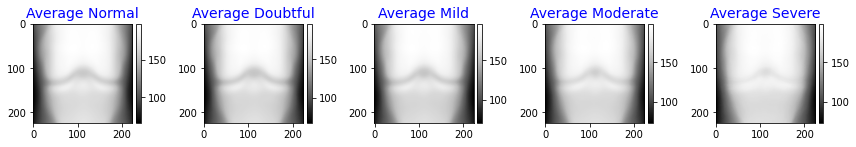

In [10]:
# Plotting mean image matrix for all classes

plt.figure(figsize = (12,6))

subplot_index = 0
mean_images_all_class = []
for i in range(len(all_class_names)):
    
    plt_label = f"Average {KL_grading[i]}"
    
    subplot_index += 1
    
    ax = plt.subplot(1, len(all_class_names), subplot_index)
    
    images_1D_this_class = images_1D_all_class[i]
    
    mean_img_this_class = estimate_plot_mean_img(ax, images_1D_this_class, 
                                      plt_label, image_size)
    
    mean_images_all_class.append(mean_img_this_class)
    
plt.tight_layout()
plt.show()

We can see from the **average** images that the "gap" between two bones in the knee reduces as the KL grading increases from 'Normal' ('0') to 'Severe' ('4') conditions, which is consistent with our previous observation. This in turn gradually blurs out the edges of the two bones because the two bones starts grinding against each other creating significant pains for the patients.

## 2.6 Contrast Between Average Images<a id='2.6_Contrast_Between_Average_Images'></a>

Using the average images, we can also compute the difference between two average images of diffferent conditions.

In [11]:
def estimate_plot_diff_images(ax, image1, image2, title):
    # Calculate the difference between the two images
    contrast_image = image2 - image1
    
    imgplot  = ax.imshow(contrast_image, cmap = 'Greys_r')
    ax.set_title(title, color='blue', fontsize=14)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(imgplot, cax=cax)
    
    return contrast_image

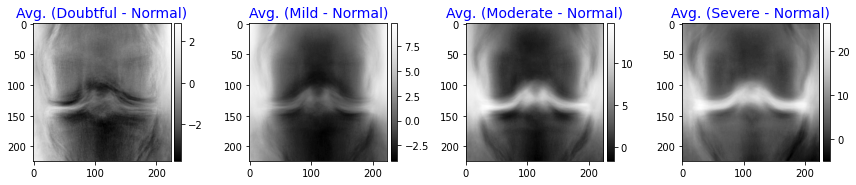

In [12]:
plt.figure(figsize = (12,6))

subplot_index = 0
mean_diff_images = []
for i in range(1,len(all_class_names)):
    
    plt_label = f"Avg. ({KL_grading[i]} - {KL_grading[0]})"
    
    subplot_index += 1
    
    ax = plt.subplot(1, len(all_class_names)-1, subplot_index)

    mean_diff = estimate_plot_diff_images(ax, mean_images_all_class[0], mean_images_all_class[i], plt_label)
    
    mean_diff_images.append(mean_diff)
    
plt.tight_layout()
plt.show()

It is clear that the average or representative osteoarthritis condition shows increasingly more difference in the image values, particularly, in the knee "gap" region, relative to the average or representative healthly/normal knee condtion as the KL grading increases from `1` ('Doubtful') to `4` ('Severe').

We will now follow `Matplotlib`'s `imshow`'s (re: [matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)) documentation, in particular, a short tutorial on plotting images with `Matplotlib` (re: [Image tutorial](https://matplotlib.org/stable/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py)) to investigate a bit more.

**<u>Examining a specific data range</u>**:

Let us start by printing the `mean_diff` between average of normal image and average of severe image (this is the last average we computed within the `for` loop above).

In [13]:
mean_diff

array([[10.170738 ,  9.810326 ,  9.575584 , ...,  6.3245773,  6.6083603,
         6.8235397],
       [10.260384 ,  9.854706 ,  9.688324 , ...,  6.8806534,  7.1199646,
         7.371872 ],
       [10.406395 , 10.053986 ,  9.783867 , ...,  7.032631 ,  7.2123795,
         7.317322 ],
       ...,
       [ 3.2759476,  3.0580826,  3.032547 , ..., -2.947441 , -2.9946365,
        -2.6743774],
       [ 3.004158 ,  2.964714 ,  2.9189377, ..., -3.2050323, -3.1769562,
        -2.8270416],
       [ 3.1447525,  2.9657135,  2.9579086, ..., -3.3607254, -3.0748901,
        -2.800003 ]], dtype=float32)

We want to enhance the contrast in our `mean_diff` image data in the "gap" region, or expand the contrast in that region while sacrificing the detail in colors that don't vary much, or don't matter, or is not of much interest. A good tool to find interesting regions is the **histogram**. To create a histogram of our image data, we use the `hist()` function.

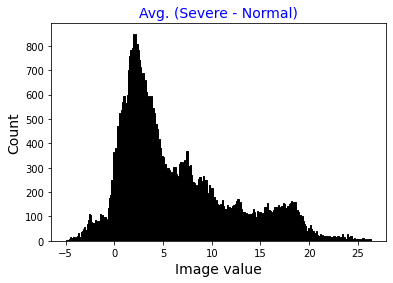

In [14]:
# Following the  Matplotlib's Image tutorial mentioned above, let us assign
# a variable 'lum_img' to our luminosity (2D, no color) image of mean_diff.
# Recall that we already have single-channel, grayscale, luminosity images. 
# So, 'lum_img' and 'mean_diff' are precisely same for our case.

lum_img = mean_diff
n, bins, patches = plt.hist(lum_img.ravel(), bins=256, fc='k', ec='k')
plt.xlabel('Image value',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.title(plt_label, color='blue', fontsize=14);

We can see from the histogram that most of the image data values of this `mean_diff` are around peak, but that is not of interest since it's away from the "gap" region. There's not much useful information in that peak region for our case. Let's adjust the lower limit, so that we effectively "zoom in on" the histogram above 4. We do this by passing the `clim` argument to `imshow`. We could also do this by calling the `set_clim()` method of the image plot object.

With a luminosity (2D, no color) image, the default colormap (aka lookup table, LUT), is applied. The default colormap is called `viridis` (see [Choosing Colormaps in Matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html)). There are plenty of others to choose from. We have already used `cmap='Greys_r'` in our function `estimate_plot_diff_mean_img()` to display the images in gray colormap. We can choose the same or a different `cmap` option. Below, we choose `cmap="hot"` to show better contrast.

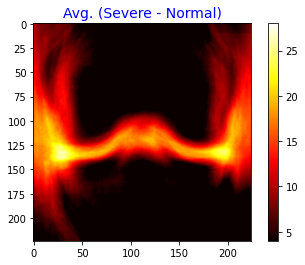

In [15]:
plt.imshow(lum_img, clim=(4, 28), cmap="hot")
plt.colorbar()
plt.title(plt_label, color='blue', fontsize=14);

Let us now write a function to plot all the histograms and all the `mean_diff` images using `cmap="hot"` for enhanced contrast for all the osteoarthritis conditions relative normal condition. This will help us to see how the different **average** knee OA conditions changes relative to the average healthy or normal knee condtion (i.e., 'Normal' condition).

In [16]:
def estimate_plot_hist(ax, lum_img, hist_range, bins):
    
    # Estimate histogram
    n, bins, patches = ax.hist(lum_img.ravel(), bins=bins, range=hist_range, fc='k', ec='k')
    
    return n, bins

def plot_hist_images(images, hist_range = None, titles = None, clim = None, suptitle = None):
    
    plt.figure(figsize = (12,6))

    subplot_index_hist = 0
    subplot_index_image = 4
    for i in range(len(images)):
    
        subplot_index_hist += 1
        subplot_index_image += 1
    
        lum_img = images[i]
    
        # Histogram plot
        ax_hist = plt.subplot(2, len(images), subplot_index_hist)
        n, bins = estimate_plot_hist(ax_hist, lum_img, hist_range, bins = 256)
        ax_hist.set_ylabel('Count', fontsize=14)
        
        if titles is not None:
            plt_label = titles[i]            
            ax_hist.set_title(plt_label, color='blue', fontsize=14)
    
        # Image plot
        ax_img = plt.subplot(2, len(images), subplot_index_image)
        imgplot = ax_img.imshow(lum_img, clim=clim, cmap="hot")
        
        divider = make_axes_locatable(ax_img)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)

    if suptitle is not None:
        plt.suptitle(suptitle, color='magenta', fontsize = 20)

    plt.tight_layout()
    plt.show()

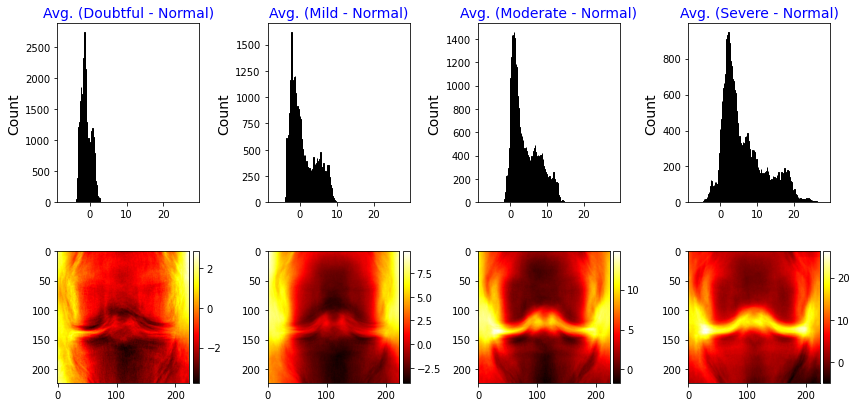

In [17]:
base_KL_grading = KL_grading[0]
titles = []
for i in range(len(mean_diff_images)):
    this_KL_grading = KL_grading[i+1]
    this_tile = f"Avg. ({this_KL_grading} - {base_KL_grading})"
    titles.append(this_tile)
    
hist_range = (-7, 28)
plot_hist_images(mean_diff_images, hist_range, titles)

+ `Avg. (Doubtful - Normal)`: The `mean_diff` image values here are mostly restricted to smaller values betweeen `[-3,2]`. We see that the "gap" region between two bones has image values close to `0`, i.e., around `[-2,1]`, implying that the difference between average images of 'Doubtful' condition and 'Normal' condition is negligible. This is expected.

+ `Avg. (Mild - Normal)`:  The `mean_diff` image values here increased more from the previous case. They are now between `[-4, 10]` crossing the maximum (approximate maximum) value of `2` that we observed earlier for the `Doubtful` condition. The "gap" between two bones has difference of image values about `[-2,2]`, which is still close to `0`. This indicates that 'Mild' osteoarthritis condition deviates only slightly from the 'Normal' conidition.

+ `Avg. (Moderate - Normal)`: The difference of image values here extended beyond `10`. The higher values are particularly showing up more around the knee "gap" region signifying more damage in the knee due to osteoarthritis condition.

+ `Avg. (Severe - Normal)`: The difference in average image values now extended upto `25` with the higher range of these values particularly appearing around the knee "gap" region, signifying severe damage in the knee due to the 'Severe' condition.

From this analysis of **Contrast Between Average Images**, it is clear that the average (or, representative) image values of diferent knee OA conditions (from 'Doubtful' to 'Severe' gradings) increasingly deviate further from the average (or representative) image values of healthly/normal knee condition, particularly, in the knee "gap" region. This implies increasingly worsening conditions of the patients.

#### Histogram Plots of "Difference" of *Individual* Images and *Average* Normal Image

It will also be interesting to see how a few randomly sampled individual images of different classes (*not averaged* over all samples of a given class) differ from *average*  (or representative) image values of the healthly/normal knee condition. We collected a few randomly selected images from different classes in the list variable `random_images_list`. We will now compute the *difference* of each of these individual images from the *average* healthly/normal knee image. Then, we will plot both the histogram and display the image for this set of *difference* images.

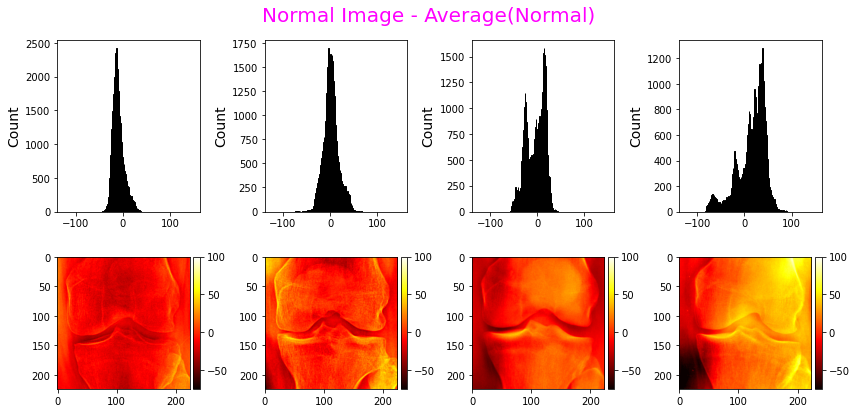

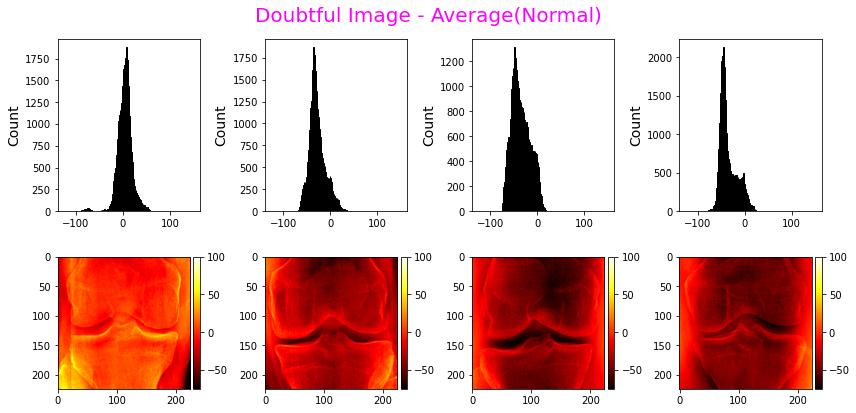

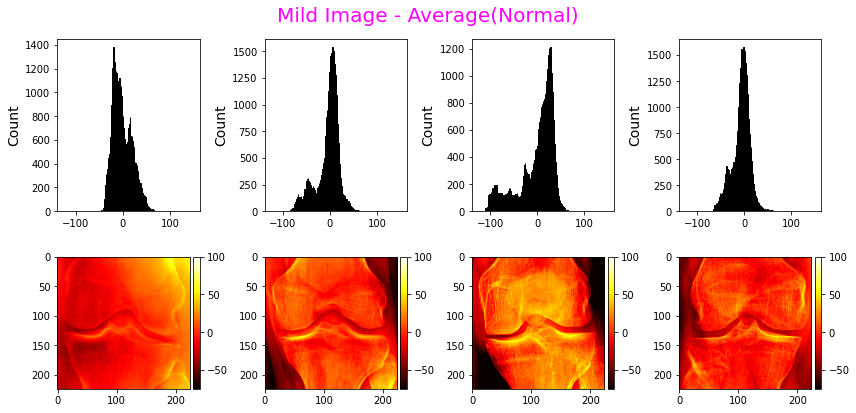

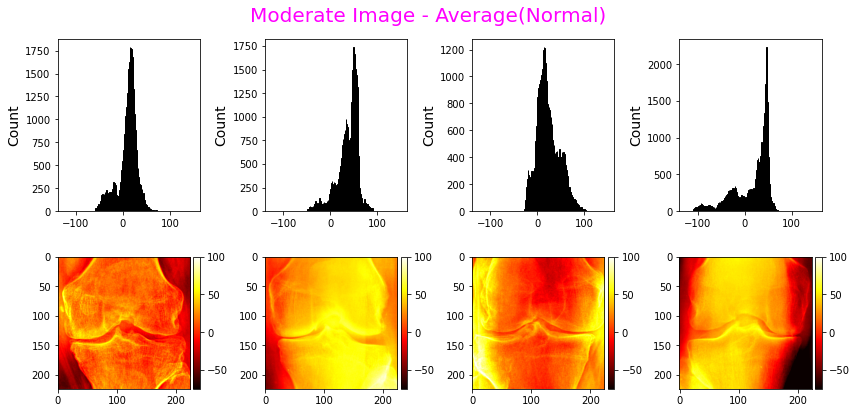

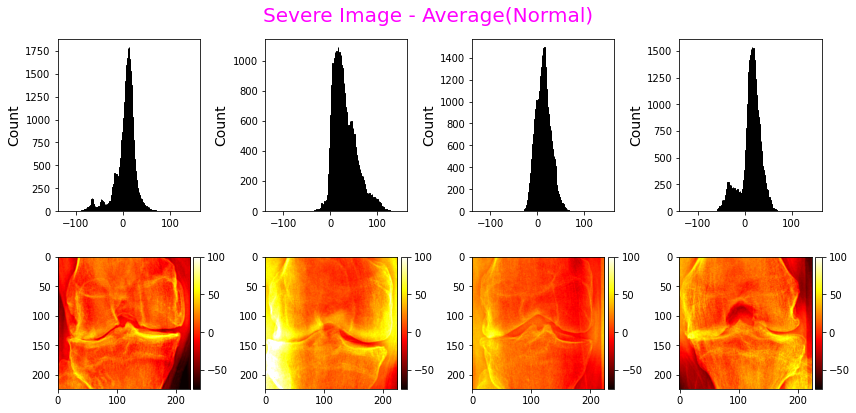

In [18]:
normal_mean_img = mean_images_all_class[0]

for i in range(len(all_class_names)):
    
    plt_label = f"{KL_grading[i]} Image - Average({KL_grading[0]})"
    
    difference_images_this_class = []
    for j in range(n_image):
        
        image_path = f'{combined_folder_path}{all_class_names[i]}/{random_images_list[i][j]}'
    
        image = tf.keras.preprocessing.image.load_img(image_path,
                                                  color_mode=color_mode,
                                                  interpolation="bilinear")
        img_matrix = tf.keras.preprocessing.image.img_to_array(image, dtype = "float32")[:,:,0]
        
        difference_image = img_matrix - normal_mean_img
        
        KL_div = np.array([entropy(img_matrix.ravel(), normal_mean_img.ravel())])
        
        if j == 0:
            KL_div_this_class = KL_div
        else:
            KL_div_this_class = np.concatenate((KL_div_this_class, KL_div))
        
        difference_images_this_class.append(difference_image)
    
    KL_div_this_class = KL_div_this_class.reshape(1,-1)
    if i == 0:
        KL_div_all_class = KL_div_this_class
    else:
        KL_div_all_class = np.concatenate((KL_div_all_class,KL_div_this_class), axis = 0)
        
    plot_hist_images(difference_images_this_class,
                     hist_range = (-125, 150),
                     clim = (-75, 100),
                     suptitle = plt_label)

It seems there is no discernible features neither in the histogram nor in the image plot for the set of all the *difference* images that we considered above.

We can also check Kullback-Leibler (KL) divergence values that we computed above based on each histogram of the images relative to the histogram of the average normal knee image.

In [19]:
KL_div_df = pd.DataFrame(KL_div_all_class,
                         columns = ['Image 1', 'Image 2', 'Image 3', 'Image 4'],
                         index = KL_grading)
KL_div_df

Image 1   Image 2   Image 3   Image 4
Normal    0.003271  0.006538  0.011416  0.024454
Doubtful  0.008478  0.008330  0.006977  0.006448
Mild      0.010846  0.022675  0.052316  0.012794
Moderate  0.010384  0.008082  0.014685  0.043709
Severe    0.015791  0.016054  0.006165  0.011431

Again, we cannot make any significant comment by observing the values of KL divergence above.

## 2.7 Variability<a id='2.7_Variability'></a>

Similarly, we can also compute variance or standard deviation of image values at each pixel to investigate which region of the knee images shows more variablity for different classes. 

The standard deviation of image values at each pixel can be collected together for all pixels for a given class ('Normal', 'Doubtful', 'Mild',.. ). These collected values of standard deviation can now be plotted as histogram for each class to get an idea about how the standard deviation values of a region, particularly, the "gap" region, change across different classes.

In [20]:
def estimate_std_img_all_class(images_1D_all_class,image_size):
    
    std_images_all_class = []
    
    for i in range(len(images_1D_all_class)):
    
        images_1D_this_class = images_1D_all_class[i]
        
        # Calculate the standard deviation at each pixel
        std_img_this_class = np.std(images_1D_this_class, axis = 0)
    
        # Reshape it back to a matrix.
        std_img_this_class = std_img_this_class.reshape(image_size)
    
        std_images_all_class.append(std_img_this_class)
    
    
    return std_images_all_class

# Call the funciton
std_images_all_class = estimate_std_img_all_class(images_1D_all_class,image_size)

In [21]:
def plot_hist_image_std(std_images_all_class,KL_grading,xlim = None,ylim = None,clim = None):

    plt.figure(figsize = (12,6))

    subplot_index_hist = 0
    subplot_index_image = 5
    
    for i in range(len(std_images_all_class)):
    
        plt_label = f"Std. {KL_grading[i]}"
    
        subplot_index_hist += 1
        subplot_index_image += 1
    
        ax_hist = plt.subplot(2, len(KL_grading), subplot_index_hist)
        ax_img = plt.subplot(2, len(KL_grading), subplot_index_image)
    
        lum_img = std_images_all_class[i] # i.e., lum_img = std_img_this_class
        
        # Histogram plot for each channel
        ax_hist.hist(lum_img.ravel(), bins=256, fc='k', ec='k')
        ax_hist.set_xlabel('std. dev. of image values', fontsize=10)
        ax_hist.set_ylabel('Count', fontsize=14)
        ax_hist.set_title(plt_label, color='blue', fontsize=14)
        ax_hist.set_xlim(xlim)
        ax_hist.set_ylim(ylim)
        

        # Image plot for each chanel
        imgplot = ax_img.imshow(lum_img, clim=clim, cmap="hot")
        divider = make_axes_locatable(ax_img)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)

        
    # Global title over all subplots
    # https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
    plt.suptitle(f"Histograms of std. dev. of pixel values", color='magenta', fontsize = 20)
    
    plt.tight_layout()
    plt.show()

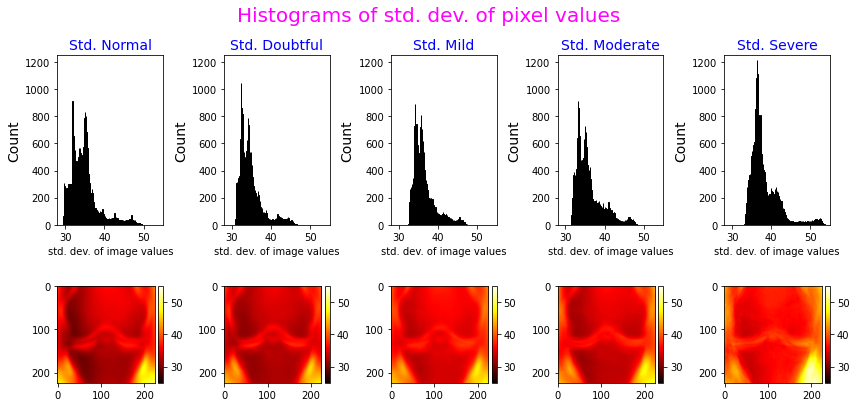

In [22]:
xlim = (28, 55)
ylim = (0,1250)
clim = (25,55)

plot_hist_image_std(std_images_all_class,KL_grading,xlim,ylim,clim)

We observe that peak of the histogtam of standard deviation image values moves righward (i.e., increases) as KL grading increases from '0' to '4' condition. The maximum value of the histogtam also shifts (moves) rightward simultaneously. This indicates that the variability in images increases as the knee osteoarthritis condition worsens.

Consistent with the above observation, we also notice that the articular cartilage (the "gap") region between two bones shows higher ranges of standard deviation (i.e., more variability) as the condition of the knee deteriorates. We also clearly see that the standard deviation of 'Normal' ('0') images show more clear sharp **edge features** whereas the edges get blurer as we move towards 'Severe' ('4') images.

Another point to note is that the "gap" region typically has standard deviation values around ~35-40 for all the classes. However, the **counts** of values in this range, as we see from the histogram plots, increase significantly from less than 100 for 'Normal' condition to more than 250 for 'Severe' condition.

## 2.8 Eigenimages<a id='2.8_Eigenimages'></a>

Lastly, we can use a dimension reduction technique such as the principal component analysis (PCA) to visualize the components that describe **each class** the best. More infromation on PCA can be found here - https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
The eigenimages, which is essentially the eigenvectors (components) of PCA associated with our samples of image matrices, can be reshaped into a matrix and be plotted. This approach was first used for facial recognition research, where the eigenimages were called eigenfaces. Here, we will visualize the first 3 dominant principal components for **each class**.

For this section, we have already imported `PCA` class from `sklearn.decomposition` (re: [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

Recall that `images_1D_this_class` is an (`n_samples`, `n_features`) matrix obtained as output from `get_n_by_m_matrix()` for a given class.

In [23]:
def eigenimages(flattened_images, n_components = 3, svd_solver = "randomized"):
    
    # fit PCA to describe n_comp * variability in the class
    pca_estimator = PCA(n_components = n_components,
                        svd_solver=svd_solver,
                        whiten = True,
                        random_state = 42)
    pca_estimator.fit(flattened_images)
    
    return pca_estimator

The 'pca_estimator_all_class' already determined. Loading it...

class 0: PCA(n_components=3, random_state=42, svd_solver='randomized', whiten=True)

class 1: PCA(n_components=3, random_state=42, svd_solver='randomized', whiten=True)

class 2: PCA(n_components=3, random_state=42, svd_solver='randomized', whiten=True)

class 3: PCA(n_components=3, random_state=42, svd_solver='randomized', whiten=True)

class 4: PCA(n_components=3, random_state=42, svd_solver='randomized', whiten=True)


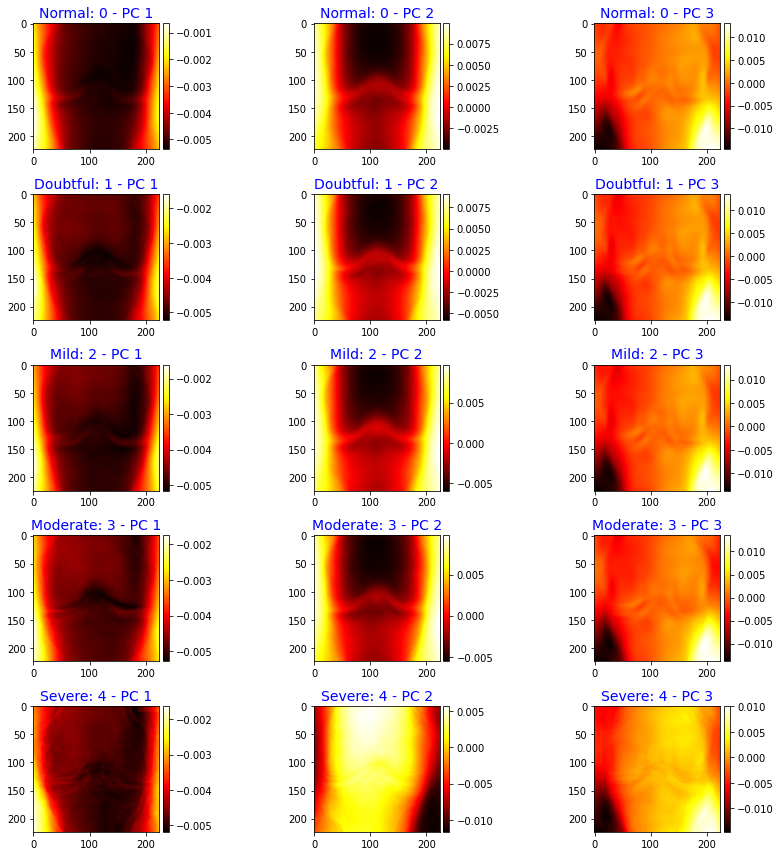

In [24]:
file_exists = os.path.exists("3_EDA_pca_estimator_all_class.pkl")

if file_exists:
    print(f"The 'pca_estimator_all_class' already determined. Loading it...")
    
    # Loading the 'pca_estimator_all_class'
    with open('3_EDA_pca_estimator_all_class.pkl', 'rb') as f:
        pca_estimator_all_class = pickle.load(f)
        
        
plt.figure(figsize = (12,12))

if file_exists == False:
    pca_estimator_all_class = []
    
subplot_index = 0    
for i in range(len(all_class_names)):
    
    if file_exists:
        pca_estimator_this_class = pca_estimator_all_class[i]
        
    else:
        images_1D_this_class = images_1D_all_class[i]
        pca_estimator_this_class = eigenimages(images_1D_this_class)
        pca_estimator_all_class.append(pca_estimator_this_class)
    
    print(f"\nclass {i}: {pca_estimator_this_class}")
    
    n_components = pca_estimator_this_class.n_components_
    
    for j in range(n_components):
        
        subplot_index += 1
    
        ax = plt.subplot(len(all_class_names), n_components, subplot_index)
    
        imgplot = ax.imshow(pca_estimator_this_class.components_[j].reshape(image_size), cmap="hot")
        
        plt_label = f"{KL_grading[i]}: {all_class_names[i]} - PC {j+1}"
        ax.set_title(plt_label,color='blue', fontsize=14)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)
        
plt.tight_layout()
plt.show()

if file_exists == False:
    # 'pca_estimator_all_class' is saved next because it is computationally
    # expensive to compute.

    # Saving the variable:
    with open('3_EDA_pca_estimator_all_class.pkl', 'wb') as f:
        pickle.dump(pca_estimator_all_class, f)

The eigenimages of X-ray images of the first 4 classes ('Normal', 'Doubtful', 'Mild', and 'Moderate') show more clear edge features and "gap" region in all the 3 dominant eigenimages, while the 3 dominant eigenimages of the 'Severe' class are not capable of extracting the edge features and "gap" region. This again implies that the edge features and the "gap" region get significantly distorted for 'Severe' class, signifying damage in the knee.

## 2.9 Edge Features using `scikit-image`<a id='2.9_Edge_Features_using_scikit_image'></a>

Since the edge features or the "gap" region increasingly distort as the knee OA conditions deteriorates, we can visuallize it using `scikit-image`. You may refer to this image processing [tutorial](https://scipy-lectures.org/packages/scikit-image/index.html) using `scikit-image` for further details. The following code will follow the [General examples](https://scikit-image.org/docs/dev/auto_examples/) page, in particular, the example on [Edge operators](https://scikit-image.org/docs/dev/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py).

Let us try to extrct the edge features of the 3 dominant eigenimages computed above for all the 5 classes using `scikit-image`.

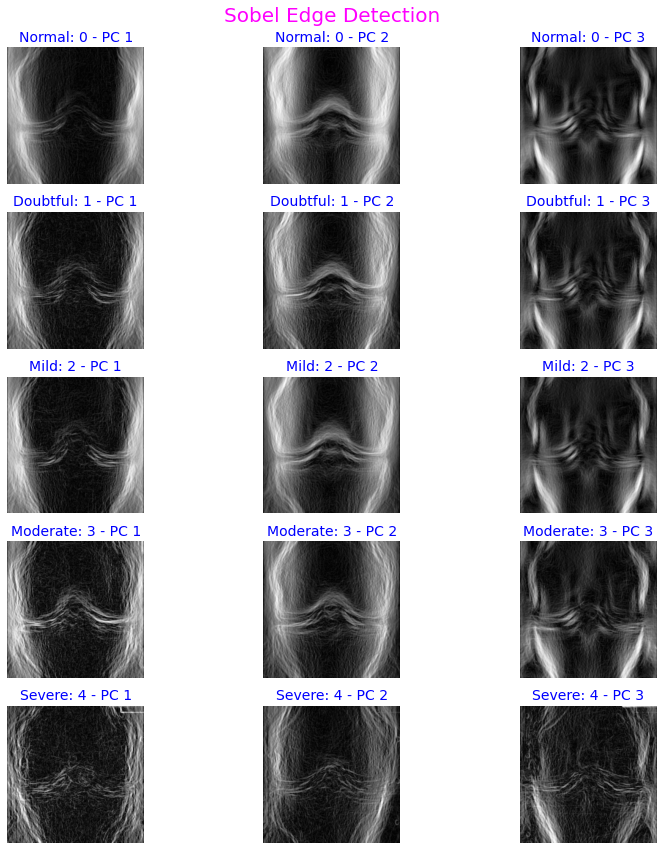

In [25]:
plt.figure(figsize = (12,12))

subplot_index = 0

for i in range(len(all_class_names)):
    
    pca_estimator_this_class = pca_estimator_all_class[i]
    
    n_components = pca_estimator_this_class.n_components_
    
    for j in range(n_components):
        
        subplot_index += 1
    
        ax = plt.subplot(len(all_class_names), n_components, subplot_index)
        
        image = pca_estimator_this_class.components_[j].reshape(image_size)

        edge_sobel = filters.sobel(image)
        
        ax.imshow(edge_sobel, cmap='Greys_r')
        
        plt_label = f"{KL_grading[i]}: {all_class_names[i]} - PC {j+1}"
        ax.set_title(plt_label,color='blue', fontsize=14)
    
        ax.axis('off')
        
# Global title over all subplots
# https://stackoverflow.com/questions/7526625/matplotlib-global-legend-and-title-aside-subplots
plt.suptitle(f"Sobel Edge Detection", color='magenta', fontsize = 20)

plt.tight_layout()
plt.show()

The edges features get more entangled or start crossing each other significantly as the knee condition deteriorates from 'Normal' to 'Severe'.

Instead of extracting the edge features of the eigenimages as we did above, we can also plot the edge features of the X-ray images direcctly. Let us consider the randomly sampled images of different classes that we considered earlier. We collected those images in the list variable `random_images_list`. We will now plot these images with their edge features.

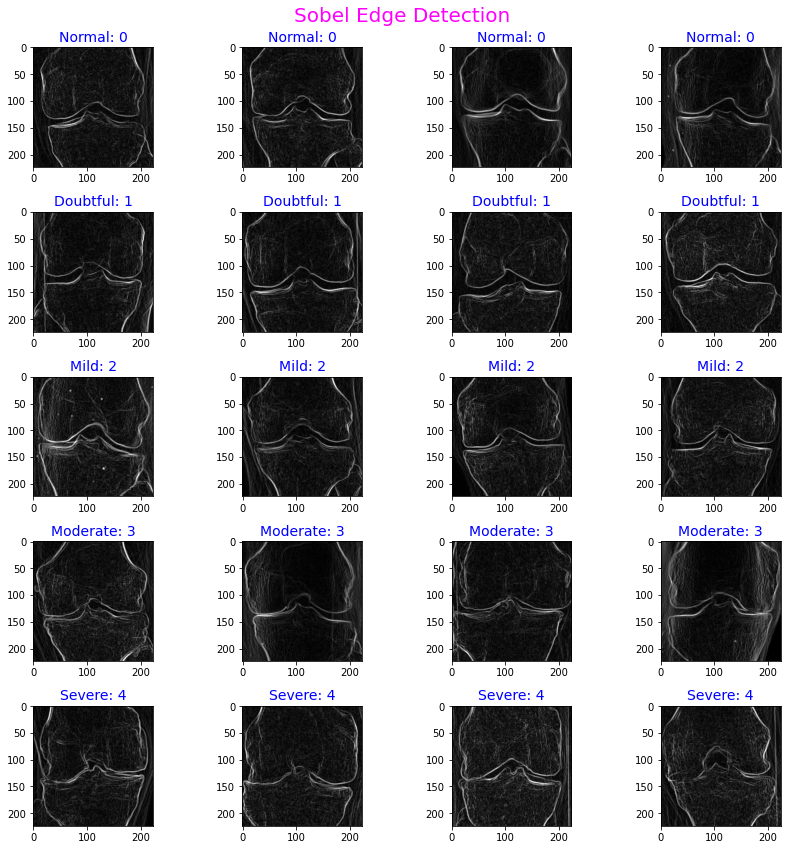

In [26]:
plt.figure(figsize = (12,12))

subplot_index = 0
for i in range(len(all_class_names)):
    
    plt_label = KL_grading[i]+': '+all_class_names[i]
    
    for j in range(n_image):
        
        subplot_index += 1
    
        image_path = f'{combined_folder_path}{all_class_names[i]}/{random_images_list[i][j]}'
    
        ax = plt.subplot(len(all_class_names), n_image, subplot_index)
    
        image = tf.keras.preprocessing.image.load_img(image_path,
                                                  color_mode=color_mode,
                                                  interpolation="bilinear")
        img_matrix = tf.keras.preprocessing.image.img_to_array(image, dtype = "float32")
        
        edge_sobel = filters.sobel(img_matrix)
        
        ax.imshow(edge_sobel, cmap='Greys_r')
        
        plt_label = f"{KL_grading[i]}: {all_class_names[i]}"
        ax.set_title(plt_label,color='blue', fontsize=14)
    
        # ax.axis('off')
        
plt.suptitle(f"Sobel Edge Detection", color='magenta', fontsize = 20)

plt.tight_layout()
plt.show()

In [27]:
type(edge_sobel), np.shape(edge_sobel)

(numpy.ndarray, (224, 224, 1))

The edge features matrix computed as `edge_sobel` are plotted above. The plots show distinct edge features depending on different classes ('Normal', ... 'Severe').

In the modeling section, it might be interesting to **incldue the edge features matrix, `edge_sobel`, of each image as additional features or input variables.**

In the following section, we will do a prelimnary investigation based on **eigenimage based classification** of the images. We will follow this [article](https://nicholastsmith.wordpress.com/2016/02/18/eigenfaces-versus-fisherfaces-on-the-faces94-database-with-scikit-learn/) for this purrpose.

## 2.10 Eigenimage based Classification

Recall that in [Section 2.8](#2.8_Eigenimages), first 3 dominant eigenimages were computed for each class separately. In this section of eigenbased image classifivcation, we will consider all the `images_1D_this_class` matrices of all the classes and collect them together in a bigger matrix for which we will find the first 3 dominant eigenimages (or principal components). Reacall that each `images_1D_this_class` matrix is an (`n_samples`, `n_features`) matrix for a given class, where `n_samples` is the number of images for each class and `n_features` is given by `np.prod(image_size) = 224 × 224 = 50176` which is the number of pixels of each image (i.e., the number of features). In other words, each row of `images_1D_this_class` corresponds to a single flattened image for a given class.

Also, recall from [Section 2.4](#2.4_Images_as_Matrix) that all the 5 `images_1D_this_class` matrices were collected in a ragged list ,`images_1D_all_class`. Each element of this raggeddd list, `images_1D_all_class`, is  an `numpy.ndarray` or a matrix of size (`n_samples`, `n_features`). Here, `n_samples` varies over different classes but `n_features` is same for all images across all classes.

In [28]:
total_samples = 0
for i in range(len(images_1D_all_class)):
    print(f"class: {i}")
    n_samples = np.shape(images_1D_all_class[i])[0]
    n_features = np.shape(images_1D_all_class[i])[1]
    print(f"\t(n_samples,n_features) = ({n_samples}, {n_features})\n")
    total_samples = total_samples + n_samples

class: 0
	(n_samples,n_features) = (3857, 50176)

class: 1
	(n_samples,n_features) = (1770, 50176)

class: 2
	(n_samples,n_features) = (2578, 50176)

class: 3
	(n_samples,n_features) = (1286, 50176)

class: 4
	(n_samples,n_features) = (295, 50176)



We will now collect all the `images_1D_this_class` matrices in a bigger matrix `A`. Each row of `A` will correspond to a single flattened image. We will also create a target or label vector `y` that will refer to the corresponding class, i.e., `0`, `1`, `2`, `3`, and `4`.

In [29]:
print(f"\nThe shape of bigger matrix 'A' will be: ({total_samples}, {n_features}).\n")
print(f"\nThe shape of 'y' vector will be: ({total_samples},).\n")


The shape of bigger matrix 'A' will be: (9786, 50176).


The shape of 'y' vector will be: (9786,).



In [30]:
for i in range(len(images_1D_all_class)):
    
    images_1D_this_class = images_1D_all_class[i]

    if i == 0:
        A = images_1D_this_class
        y = i*np.ones(np.shape(images_1D_this_class)[0])
    elif i > 0:
        A = np.concatenate((A, images_1D_this_class))
        
        target_vector = i*np.ones(np.shape(images_1D_this_class)[0])
        y = np.concatenate((y, target_vector))

print(f"np.shape(A): {np.shape(A)}\n")
print(f"np.shape(y): {np.shape(y)}\n")

np.shape(A): (9786, 50176)

np.shape(y): (9786,)



We can now determine the first 3 dominant principal components or eigenimages based on this overall matrix `A`.

In [31]:
# Determine the eigenimages

file_exists = os.path.exists("3_EDA_pca_estimator_A.pkl")

if file_exists:
    print(f"The 'pca_estimator_A' already determined. Loading it...")
    
    # Loading the 'pca_estimator_A'
    with open('3_EDA_pca_estimator_A.pkl', 'rb') as f:
        pca_estimator_A = pickle.load(f)
    
    print(f"pca_estimator_A: {pca_estimator_A}")

else:
    # pca_estimator_A = eigenimages(A, n_components = 0.75, svd_solver = "full")
    pca_estimator_A = eigenimages(A, n_components = 5)

    # 'pca_estimator_A' is saved next because it is computationally expensive
    # to compute.

    # Saving the variable:
    with open('3_EDA_pca_estimator_A.pkl', 'wb') as f:
        pickle.dump(pca_estimator_A, f)

The 'pca_estimator_A' already determined. Loading it...
pca_estimator_A: PCA(n_components=5, random_state=42, svd_solver='randomized', whiten=True)


In [32]:
n_components = pca_estimator_A.n_components_
print(f"# of PC: {n_components}")

explained_variance_percentage = np.sum(pca_estimator_A.explained_variance_ratio_)
print(f"Percentage of variance explained by {n_components} components: {explained_variance_percentage}")

# of PC: 5
Percentage of variance explained by 5 components: 0.9060449004173279


Plot the first 3 dominant eigenimages.

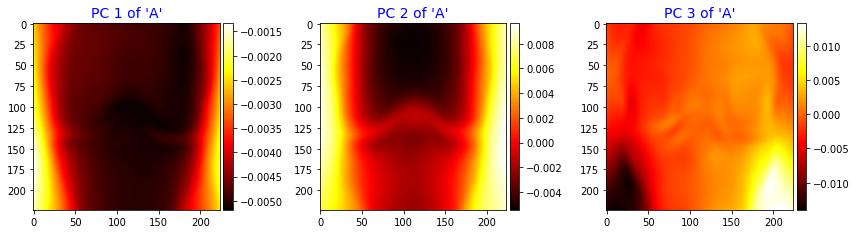

In [33]:
# Plot the eigenimages

plt.figure(figsize = (12,6))

if n_components >= 3:
    n_components_to_plot = 3
elif n_components < 3:
    n_components_to_plot = n_components

subplot_index = 0
for j in range(n_components_to_plot):
    subplot_index += 1
    ax = plt.subplot(1, n_components_to_plot, subplot_index)
    imgplot = ax.imshow(pca_estimator_A.components_[j].reshape(image_size), cmap="hot")
        
    plt_label = f"PC {j+1} of 'A'"
    ax.set_title(plt_label,color='blue', fontsize=14)
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(imgplot, cax=cax)
        
plt.tight_layout()
plt.show()

Let use now use the 5 dominant eigenimages to recosntruct a few selected images of different classes to see how the **recosntructed images** look like. See this [article](https://shankarmsy.github.io/posts/pca-sklearn.html) for more details. Let's write a function to do that. We will consider a few images from the list `random_images_list` that we created earlier.

In [34]:
for i in range(len(all_class_names)):
    
    if i == 0:
        print(f"\nNormal image files:\n")
    elif i == 1:
        print(f"\nDoubtful image files:\n")
    elif i == 2:
        print(f"\nMild image files:\n")
    elif i == 3:
        print(f"\nModerate image files:\n")
    elif i == 4:
        print(f"\nSevere image files:\n")
    
    print(f"\t{random_images_list[i]}")


Normal image files:

	['9670198_2.png' '9187595L.png' '9452628L.png' '9460076_2.png']

Doubtful image files:

	['9244516R.png' '9555397_2.png' '9150876R.png' '9698980_2.png']

Mild image files:

	['9646610L.png' '9138554L.png' '9330729L.png' '9451546_1.png']

Moderate image files:

	['9880069L.png' '9161267_2.png' '9526396R.png' '9886598R.png']

Severe image files:

	['9938636R.png' '9637958R.png' '9410340R.png' '9645683L.png']


In [35]:
# Plotting original and recosntructed images

def plot_org_PCrecons_image(j, random_images_list, pca_estimator_A,
                            combined_folder_path='KneeXrayImages/temp/',
                            all_class_names = ['0', '1', '2', '3', '4'],
                            KL_grading = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe'],
                            color_mode = "grayscale",
                            black = 0, white = 255):
    
    plt.figure(figsize = (12,6))

    subplot_index_org = 0
    subplot_index_recons = 5
    for i in range(len(all_class_names)):
    
        subplot_index_org += 1
        subplot_index_recons += 1
    
        # Plot original image
        image_path = f'{combined_folder_path}{all_class_names[i]}/{random_images_list[i][j]}'
    
        ax = plt.subplot(2, len(all_class_names), subplot_index_org)
    
        image = tf.keras.preprocessing.image.load_img(image_path,
                                                      color_mode=color_mode,
                                                      interpolation="bilinear")
        imgplot  = ax.imshow(image, vmin = black, vmax = white, cmap='hot')
        plt_label = f"{KL_grading[i]} - Original"
        ax.set_title(plt_label,color='blue', fontsize=14)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)
    
        # Reconstruct the image using PCA and plot it
        ax = plt.subplot(2, len(all_class_names), subplot_index_recons)
    
        img_matrix = tf.keras.preprocessing.image.img_to_array(image, dtype = "float32")
        img_1D = img_matrix.ravel().reshape(1,-1)
        image_1D_recons = pca_estimator_A.inverse_transform((pca_estimator_A.transform(img_1D)))
        image_recons = image_1D_recons.reshape(image_size)
    
    
        imgplot  = ax.imshow(image_recons, vmin = black, vmax = white, cmap='hot')
        plt_label = f"{KL_grading[i]} - Recons."
        ax.set_title(plt_label,color='blue', fontsize=14)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(imgplot, cax=cax)
    
    plt.tight_layout()
    plt.show()

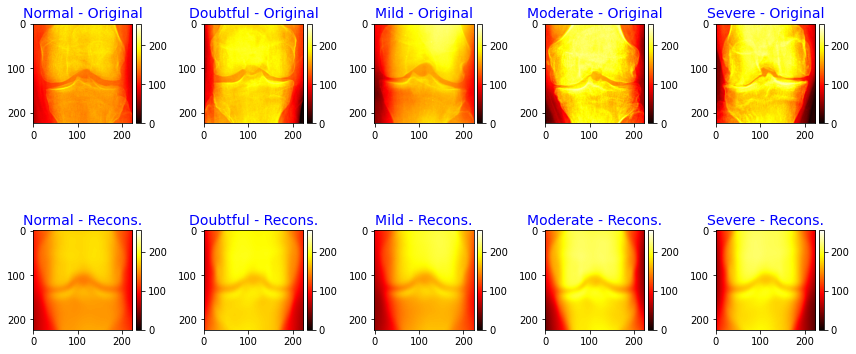

In [36]:
# Consider a set of 5 images - one from each different class. Set j = 0 
j = 0
plot_org_PCrecons_image(j, random_images_list, pca_estimator_A)

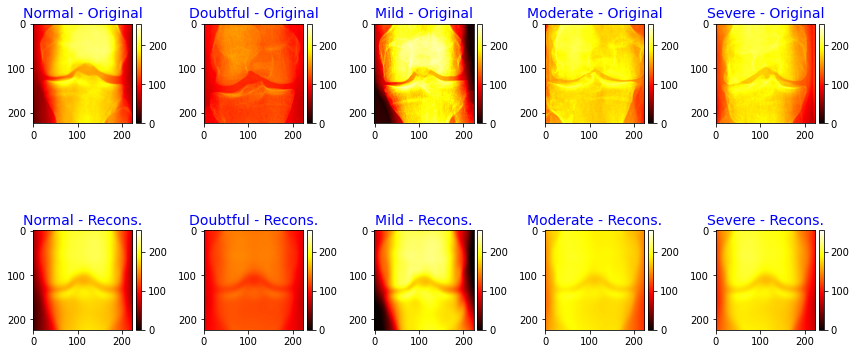

In [37]:
# Recosntruct another set of 5 images. Set j = 2.
j = 2
plot_org_PCrecons_image(j, random_images_list, pca_estimator_A)

The 2 sets of plots above are fine given that we have reconstructed them only using 5 eigenimages (principal components), while we have `n_features = 50176`. 

In [38]:
print(f"Original data size: {np.shape(A)}")

Original data size: (9786, 50176)


In [39]:
A_proj = pca_estimator_A.transform(A)
print(f"Reduced data size: {np.shape(A_proj)}")

Reduced data size: (9786, 5)


By considering only a small number of eigenimages (5 eigenimages), the dimension of the data here is greatly reduced from `(9786, 50176)` to `(9786, 5)`. Using more eigenimages, better approximation can be achieved. 

#### Plot of PCA Transformed Image Data

Using the first 3 dominant eigenimages, we will create a 3D scatter plot.

In [40]:
def plot_scatter(X, y, points_color, points_marker, title, labels):
    # fig, ax = plt.subplots(figsize=(5, 5), facecolor="white", constrained_layout=True)
    
    n_components = np.shape(X)[1]
    
    # Creating figure
    fig = plt.figure(1, figsize=(16, 9))
    
    if n_components >= 3:
        ax = fig.add_subplot(111, projection="3d")
    elif n_components == 2:
        ax = fig.add_subplot(111)

    # Add x, y gridlines
    ax.grid(visible = True, color ='grey',linestyle ='-.', 
            linewidth = 0.3, alpha = 0.2)


    # Creating plot
    for i in range(len(all_class_names)):
    
        # Ref: https://stackoverflow.com/questions/70341932/select-subset-of-rows-of-numpy-array-based-on-a-selection-of-rows-in-another-arr
        X_this_class = X[y==i]
    
        # Ref: Marker and Color: https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
        color = points_color[i]
        marker = points_marker[i]
        label = all_class_names[i]
    
        # Ref: With Legend: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
        if n_components >= 3:
            ax.scatter3D(X_this_class[:,0], X_this_class[:,1], X_this_class[:,2],
                       c=color, marker = marker, label=label,
                       alpha=0.8, edgecolor="k", s = 50)
        elif n_components == 2:
            ax.scatter(X_this_class[:,0], X_this_class[:,1],
                   c=color, marker = marker, label=label,
                   alpha=0.8, edgecolor="k", s = 50)

    ax.set_title(title, color='blue', fontsize=18)
    ax.set_xlabel(labels[0], fontsize=14)
    ax.set_ylabel(labels[1], fontsize=14)
    if n_components >= 3:
        ax.set_zlabel(labels[2], fontsize=14)

    ax.legend(bbox_to_anchor=(1.2, .5), fontsize=14)
    ax.grid(True)

    plt.show()

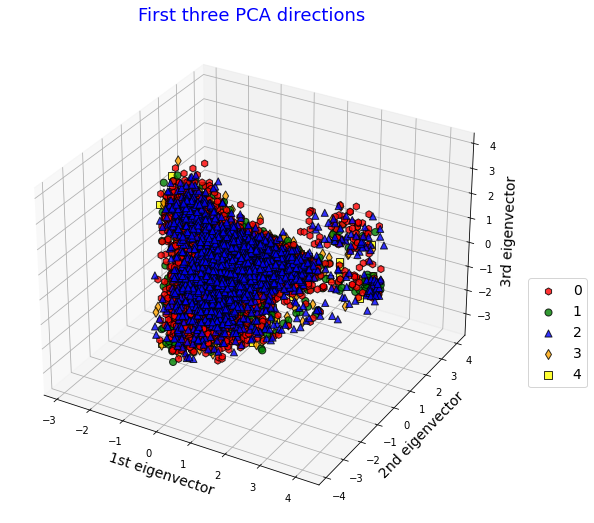

In [41]:
points_color = ['red', 'green', 'blue', 'orange', 'yellow']
points_marker = ['h', 'o', '^', 'd', 's']
title = "First three PCA directions"
labels = ["1st eigenvector", "2nd eigenvector", "3rd eigenvector"]

plot_scatter(A_proj, y, points_color, points_marker, title, labels)

Let's do the scatter plot for the first 2 dominant components as well.

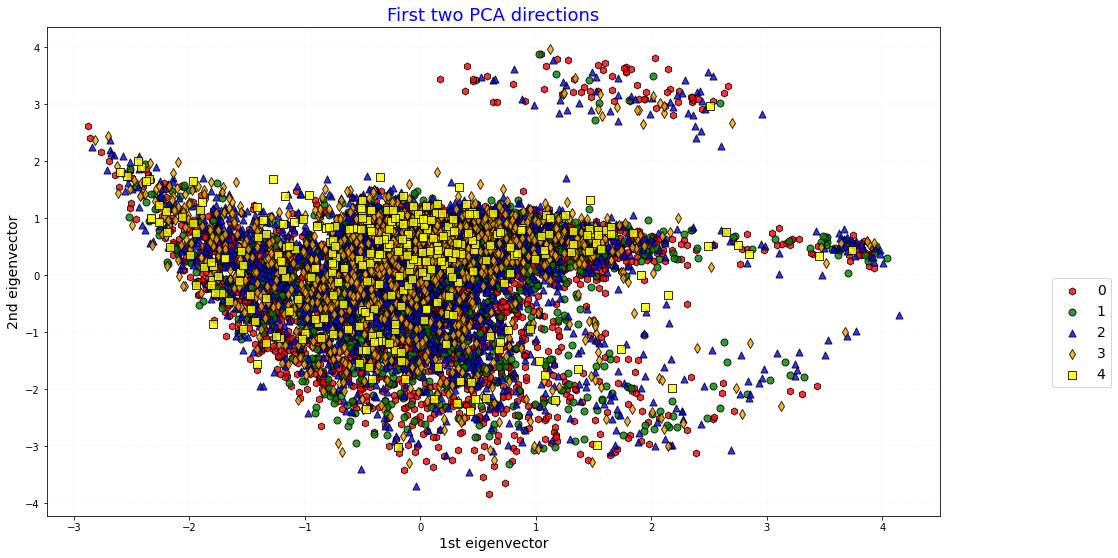

In [42]:
title = "First two PCA directions"
plot_scatter(A_proj[:,0:2], y, points_color, points_marker, title, labels)

When the data is projected to the space of the first 3 or 2 dominant PCs, the different classes ('0', '1', etc.) **cannot** be found to be well clustered. But, if we consider more number of PCs, the data **might** be well clustered. **Particularly in high-dimensional spaces, data can more easily be separated**. In fact, data can even be separated linearly. In high dimensional data, the simplicity of classifiers such as naive Bayes, k-nearest neighbors (kNN) classifier, and linear SVMs might lead to better generalization than is achieved by other classifiers.

## 2.11 T-distributed Stochastic Neighbor Embedding

Let us next consider **T-distributed Stochastic Neighbor Embedding (t-SNE)** (re: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). The t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. The t-SNE approach has a cost function that is not convex, i.e. with different initializations we can get different results. To repoduce results, we set an integer value to `random_state` parameter. Here, we set `random_state = 0`.

Three important parameters of t-SNE are `learning_rate`, `perplexity`, and `n_iter`. Here, we set `learning_rate="auto"` (this is same as *default*`learning_rate=200`; see re: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)), `perplexity=100`, and `n_iter=300`. The parameter `perplexity` is perhaps the most confusing hyperparameter of t-SNE. Loosely speaking, the intuition behind perplexity is how many neighbors each data point can “sense”. This is similar in some sense to selecting optimal k in the kNN algorithm. Tuning the hyperparameters of t-SNE can be quite tricky. For further details, “How to Use t-SNE Effectively” https://distill.pub/2016/misread-tsne/ provides a good discussion of the effects of various parameters, as well as interactive plots to explore those effects. Also, see this [article](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868) about how to tune hyperparameters of t-SNE.

One important point to note: It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples. For our image data, we have `n_features = 50176`. So, we will use the reduced or projected data `A_proj` of shape `(9786, 5)` that represents the projection of the oroginal data `A` on the space spanned by the first 5 dominants PCs. 

In [43]:
file_exists = os.path.exists("3_EDA_t_sne_Aproj_2comp.pkl")

if file_exists:
    print(f"The 't_sne' already determined. Loading it...")
    
    # Loading the 't_sne'
    with open('3_EDA_t_sne_Aproj_2comp.pkl', 'rb') as f:
        t_sne, S_t_sne = pickle.load(f)
    
    print(f"t_sne: {t_sne}")

else:
    n_components = 2
    print(f"n_components = {n_components}")

    t_sne = manifold.TSNE(
        n_components=n_components,
        learning_rate="auto",
        perplexity=100,
        n_iter=300,
        init="random",
        random_state=0,
    )
    S_t_sne = t_sne.fit_transform(A_proj)
    
    # 't_sne', and  'S_t_sne' are saved here...
    # Saving the variables:
    with open('3_EDA_t_sne_Aproj_2comp.pkl', 'wb') as f:
        pickle.dump([t_sne, S_t_sne], f)

The 't_sne' already determined. Loading it...
t_sne: TSNE(init='random', learning_rate='auto', n_iter=300, perplexity=100,
     random_state=0)


In [44]:
np.shape(S_t_sne)

(9786, 2)

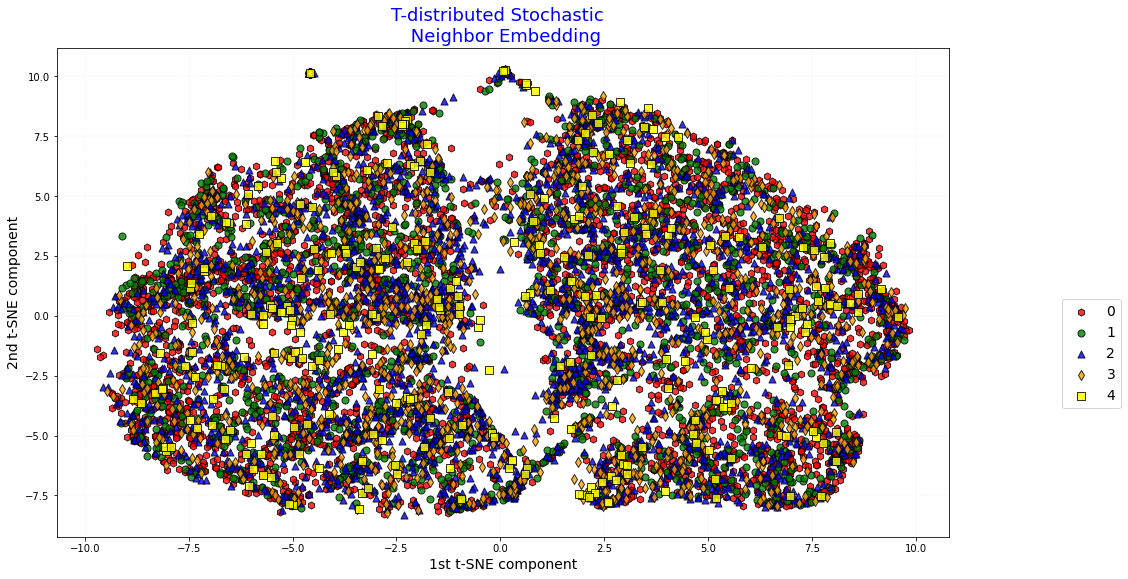

In [45]:
points_color = ['red', 'green', 'blue', 'orange', 'yellow']
points_marker = ['h', 'o', '^', 'd', 's']
title = "T-distributed Stochastic  \n Neighbor Embedding"
labels = ["1st t-SNE component", "2nd t-SNE component", "3rd t-SNE component"]

plot_scatter(S_t_sne, y, points_color, points_marker, title, labels)

Like PCAs, there is no distinct clusters for different classes. However, to provide more meaninngful comment at this stage for t-SNE, a more detailed fine tuining of the hyperparameters is required (see [this article](https://distill.pub/2016/misread-tsne/) and [this one](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)). 

## 2.12 PCA, LDA, and NCA based kNN Classification

As mentioned earlier, high-dimensional data may be more easily separated. Simple classifiers, such as naive Bayes, k-nearest neighbors (kNN) classifier, and linear SVMs might sometime provide effective and useful results. We will consider the following three different dimension reduction techniques and use kNN classifier on the projected or transformed data. This section is based on one of the `scikit-learn`'s  [illustrations](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html):

+ Principal Component Analysis (PCA) (re: [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) is applied to data to identify the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

+ Linear Discriminant Analysis (LDA) (re: [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

+ Neighborhood Components Analysis (NCA) (re: [sklearn.neighbors.NeighborhoodComponentsAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NeighborhoodComponentsAnalysis.html)) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.

For, PCA and NCA, we will consider `n_components = 5`, and for LDA, we will consider `n_components = min(n_classes - 1, n_features) = (5-1, 50176) = 4`.

n_components = 5

For LDA: n_components = 4
The 3 reduced scaled models (PCA, LDA, and NCA) already determined. Loading them...

PCA: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5, random_state=0))])

PCA: accuracy = 0.36403444752590863

PCA: recall = [0.67222222 0.13559322 0.2465374  0.07333333 0.        ]



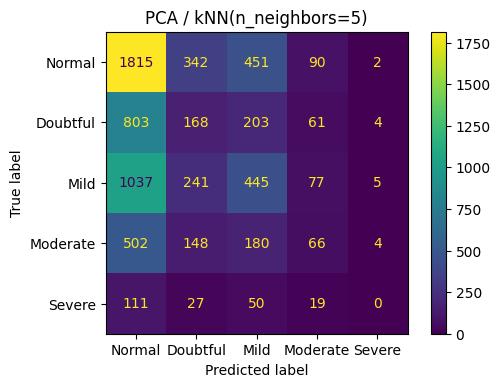

LDA: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lineardiscriminantanalysis',
                 LinearDiscriminantAnalysis(n_components=4))])

LDA: accuracy = 0.3913297328857101

LDA: recall = [0.61592593 0.17029863 0.28975069 0.29222222 0.10144928]



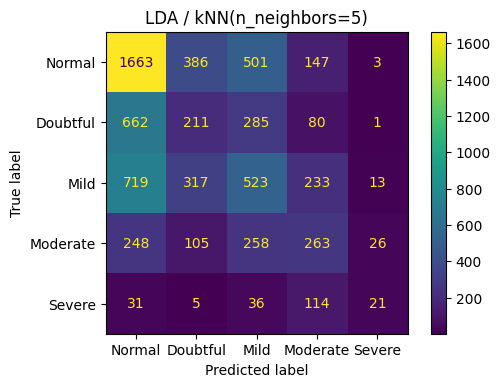

NCA: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('neighborhoodcomponentsanalysis',
                 NeighborhoodComponentsAnalysis(n_components=5,
                                                random_state=0))])

NCA: accuracy = 0.36622390891840606

NCA: recall = [0.67296296 0.14689266 0.24819945 0.06777778 0.00483092]



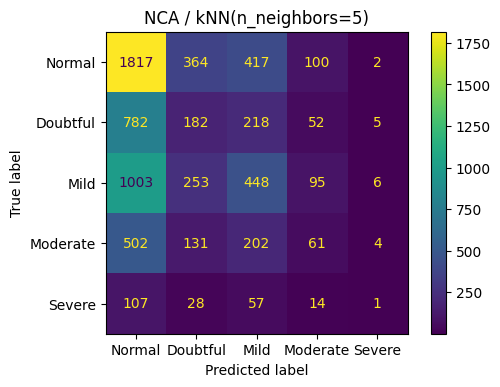

In [46]:
n_components = 5
print(f"n_components = {n_components}\n")

n_neighbors = 5

random_state = 0

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    A, y, test_size=0.7, stratify=y, random_state=random_state
)


# Reduce dimension with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=n_components, random_state=random_state))

# Reduce dimension with LinearDiscriminantAnalysis
n_classes = len(np.unique(y))
n_features = np.shape(A)[1]
min_n_components = min(n_classes - 1, n_features)
if n_components >= min_n_components:
    print(f"For LDA: n_components = {min_n_components}")
    lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=min_n_components))
elif n_components < min_n_components:
    lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=n_components))

# Reduce dimension with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=n_components, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

reduced_scaled_models = []
file_exists = os.path.exists("3_EDA_reduced_scaled_models.pkl")
if file_exists:
    print(f"The 3 reduced scaled models (PCA, LDA, and NCA) already determined. Loading them...\n")
    
    # Loading the 'reduced_scaled_models':
    with open('3_EDA_reduced_scaled_models.pkl', 'rb') as f:
        reduced_scaled_models = pickle.load(f)

for i, (name, model) in enumerate(dim_reduction_methods):
    
    # Fit the method's model or load it
    if file_exists == False:
        print(f"\nFitting {name} to training data...")
        model.fit(X_train, y_train)
        reduced_scaled_models.append(model)
    elif file_exists == True:
        model = reduced_scaled_models[i]
        print(f"{name}: {model}")

    # Fit a k-nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the k-nearest neighbor prediction on the embedded test set
    y_pred = knn.predict(model.transform(X_test))

    acc = accuracy_score(y_test, y_pred)
    recall_scr = recall_score(y_test, y_pred, average=None)
    
    print(f"\n{name}: accuracy = {acc}")
    print(f"\n{name}: recall = {recall_scr}\n")
    
    plt.figure(dpi = 100)
    ax = plt.subplot(111)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KL_grading)
    disp.plot(ax = ax)
    plt.title(f"{name} / kNN(n_neighbors={n_neighbors})")
    plt.show()

# 'reduced_scaled_models' is saved next because it is computationally expensive
# to compute.
if file_exists == False:
    # Saving the reduced_scaled_models:
    with open('3_EDA_reduced_scaled_models.pkl', 'wb') as f:
        pickle.dump(reduced_scaled_models, f)

The kNN classifier provides better results on the transformed or reduced-order data based on Linear Discriminant Analysis (LDA) than the two other dimensionality reduction technniques (PCA, and NCA) that we implemented. However, the test prediction is simply very poor. In particular, the recall score is essentially worthless for worsening knee OA conditions. The recall is intuitively the ability of the classifier to find all the positive samples (re: [sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)).

## 2.13 Classifier Comparison

We see that kNN classification based on three reduced dimensional data is not useful. Let's see if we can use the original data (without reducing) to get somewhat better results.

We will consiser several classifiers. The point of this section is to check how different classifiers work on our imbalanced image data. Note that different classfiers constuct their decision boundaries differently; see this [illustration](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) in `scikit-learn` for further details.

In [47]:
# Ref: https://stackoverflow.com/questions/18306416/adaboostclassifier-with-different-base-learners
# Ref: https://stackoverflow.com/questions/62336142/modulenotfounderror-no-module-named-sklearn-utils-testing
import sklearn
estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HalvingGridSearchCV
HalvingRandomSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


In [48]:
# names = [
#     "Nearest Neighbors",
#     "Linear SVM",
#     "RBF SVM",
#     "Gaussian Process",
#     "Decision Tree",
#     "Random Forest",
#     "Neural Net",
#     "AdaBoost",
#     "Gaussian Naive Bayes",
#     "QDA",
# ]

# classifiers = [
#     KNeighborsClassifier(n_neighbors = 30),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), random_state=41),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "Random Forest",
    "Neural Net",
    "Complement Naive Bayes",
    "AdaBoost Logistic",
    "AdaBoost LinearSVM",
]

C_SVC = 0.025
base_estimator_Logistic = SGDClassifier(loss="log", # "log" or "log_loss" = LogisticRegression()
                                        alpha = 1/C_SVC,
                                        class_weight = 'balanced')
base_estimator_LinearSVM = SGDClassifier(loss="hinge", # "hinge"/default linear SVM
                                        alpha = 1/C_SVC,
                                        class_weight = 'balanced')


classifiers = [
    KNeighborsClassifier(n_neighbors = 100, weights = 'distance'),
    SVC(C=C_SVC, kernel="linear", class_weight = 'balanced'),
    RandomForestClassifier(max_depth=25, n_estimators=100,
                           max_features="sqrt", random_state = 101, 
                           class_weight = 'balanced'),
    MLPClassifier(alpha=1, max_iter=1000, random_state = 21, 
                  early_stopping = True),
    ComplementNB(),
    AdaBoostClassifier(base_estimator = base_estimator_Logistic,
                       n_estimators = 100,
                       algorithm='SAMME',
                       random_state = 46),
    AdaBoostClassifier(base_estimator = base_estimator_LinearSVM,
                       n_estimators = 100,
                       algorithm='SAMME',
                       random_state = 46),
]

modelStandardScaler = StandardScaler()
modelStandardScaler.fit(X_train)


classifiers_models = []
y_pred_all = []

file_exists = os.path.exists("3_EDA_classifiers_models.pkl")
if file_exists:
    print(f"The classifiers models already determined. Loading them...\n")
    
    # Loading the 'classifiers_models'
    with open('3_EDA_classifiers_models.pkl', 'rb') as f:
        classifiers_models, y_pred_all = pickle.load(f)
else:

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
    
        # Fit the method's model or load it
        print(f"\nFitting {clf} to training data...")
        if name in ("Complement Naive Bayes"):
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
        else:
            clf.fit(modelStandardScaler.transform(X_train), y_train)
            y_pred = clf.predict(modelStandardScaler.transform(X_test))
            
        classifiers_models.append(clf)
        y_pred_all.append(y_pred)
                

# 'classifiers_models' and 'y_pred_all' are saved next because they are 
# computationally expensive to compute.
if file_exists == False:
    # Saving the classifiers_models:
    with open('3_EDA_classifiers_models.pkl', 'wb') as f:
        pickle.dump([classifiers_models, y_pred_all], f)

The classifiers models already determined. Loading them...



Nearest Neighbors: KNeighborsClassifier(n_neighbors=100, weights='distance')


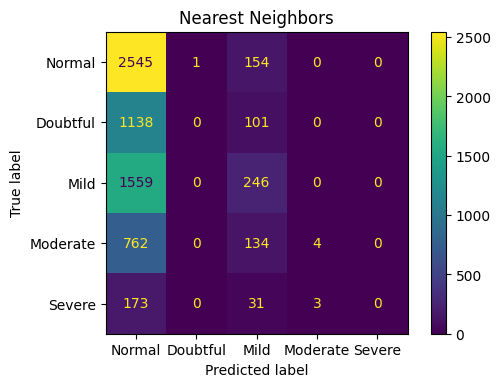

Linear SVM: SVC(C=0.025, class_weight='balanced', kernel='linear')


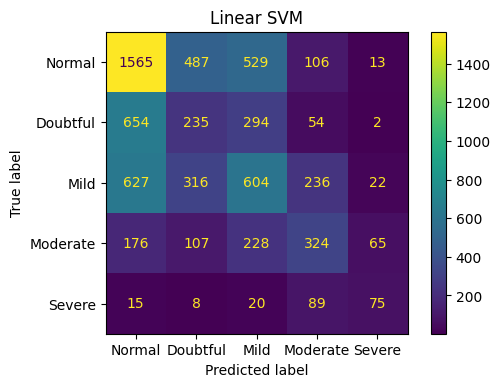

Random Forest: RandomForestClassifier(class_weight='balanced', max_depth=25,
                       max_features='sqrt', random_state=101)


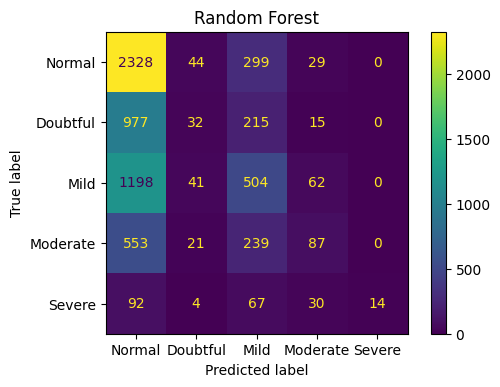

Neural Net: MLPClassifier(alpha=1, early_stopping=True, max_iter=1000, random_state=21)


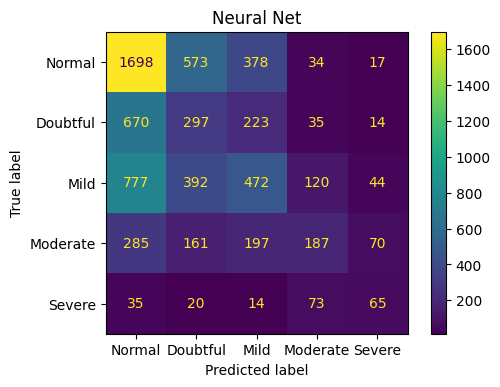

Complement Naive Bayes: ComplementNB()


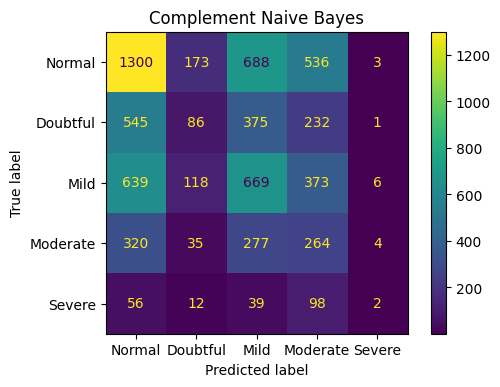

AdaBoost Logistic: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SGDClassifier(alpha=40.0,
                                                class_weight='balanced',
                                                loss='log'),
                   n_estimators=100, random_state=46)


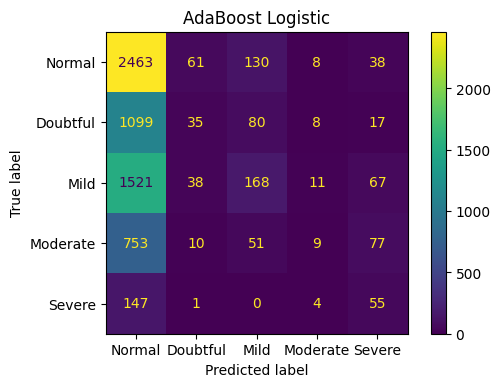

AdaBoost LinearSVM: AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=SGDClassifier(alpha=40.0,
                                                class_weight='balanced'),
                   n_estimators=100, random_state=46)


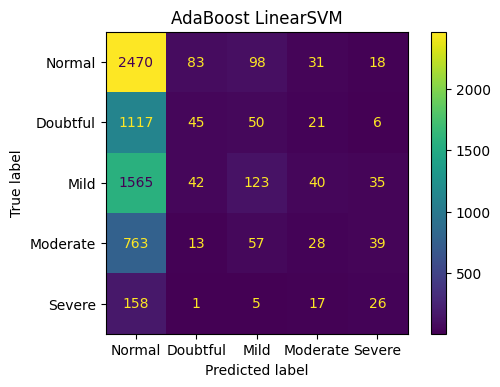

In [49]:
# Printing scores and plotting confusion matrix

i = 0
for name, clf in zip(names, classifiers):
    
    clf = classifiers_models[i]
    print(f"{name}: {clf}")
            
    y_pred = y_pred_all[i]
    
    acc = np.array([accuracy_score(y_test, y_pred)])
    recall_scr = recall_score(y_test, y_pred, average=None)
    
    if i == 0:
        scores = np.concatenate((acc, recall_scr)).reshape(1,-1)
    else:
        scores = np.concatenate((scores,
                                 np.concatenate((acc, 
                                                 recall_scr)).reshape(1,-1)),
                                axis = 0)
    
    plt.figure(dpi = 100)
    ax = plt.subplot(111)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KL_grading)
    disp.plot(ax = ax)
    plt.title(f"{name}")
    plt.show()
        
    i += 1

In [50]:
classifiers_scores = pd.DataFrame(scores,
                                  columns = ['Accuraccy','Recall_0','Recall_1', 'Recall_2', 'Recall_3', 'Recall_4'],
                                  index = names)
classifiers_scores

Accuraccy  Recall_0  Recall_1  Recall_2  Recall_3  \
Nearest Neighbors        0.407970  0.942593  0.000000  0.136288  0.004444   
Linear SVM               0.409137  0.579630  0.189669  0.334626  0.360000   
Random Forest            0.432784  0.862222  0.025827  0.279224  0.096667   
Neural Net               0.396876  0.628889  0.239709  0.261496  0.207778   
Complement Naive Bayes   0.338783  0.481481  0.069411  0.370637  0.293333   
AdaBoost Logistic        0.398482  0.912222  0.028249  0.093075  0.010000   
AdaBoost LinearSVM       0.392935  0.914815  0.036320  0.068144  0.031111   

                        Recall_4  
Nearest Neighbors       0.000000  
Linear SVM              0.362319  
Random Forest           0.067633  
Neural Net              0.314010  
Complement Naive Bayes  0.009662  
AdaBoost Logistic       0.265700  
AdaBoost LinearSVM      0.125604

None of the classifiers procuced acceptable results. Their accuracy scores are similar and in the range of 0.34 to 0.43. However, the recall scores of "Linear SVM" and "Neural Net" are slightly better, particularly, for the minority classes. The recall scores of the minority classes for the rest of classifiers are simply disastrous. These remaining classifiers have been significantly affceted by majority class samples (in particular, KL grading '0' or 'Normal' condition) which is not really of our primamry concern.

## 2.14 Remarks from EDA

+ From this analysis of difference between average image of diferent knee OA conditions ('Doubtful', 'Mild', 'Moderate', and 'Severe') and the average image of normal knee x-ray images (see [Section 2.6](#2.6_Contrast_Between_Average_Images)), we noted that the **average** (or, representative) image of the diferent knee OA conditions increasingly deviate more from the average image of the normal knee x-ray images, particularly, in the knee "gap" region. The histograms of these "difference" or "contrast" images also manifest increasingly wider range of support as knee condition worsens from 'Doubtful' to 'Severe' condition.

+  The variability in images increases as the knee osteoarthritis condition worsens. Additionally, the standard deviation of 'Normal' images show more clear sharp **edge features** whereas the edges get blurer as we move towards 'Severe' ('4') images; see [Section 2.7](#2.7_Variability).

+ In [Section 2.9](#2.9_Edge_Features_using_scikit_image), we studied the **edge features** of a few randomly selected individual images of different classes. We observed distinct edge features depending on different classes ('Normal', ... 'Severe'). In the modeling section, it might be interesting to incldue the edge features matrix, `edge_sobel`, of each image as additional features or input variables.

+ We also explored a few dimension reduction techniques (such as, PCA, LDA, NCA, and t-SNE) and plotted the projected or transformed or reduced dimensional data as 2D or 3D scatter plots. No distinct clusters for different classes were observed.

+ We also considered a few classifiers and compared their results. The accuracy scores are similar for all the classifiers (in the range of 0.34 to 0.43) and cannot be useful in practice. However, the recall scores of "Linear SVM" and "Neural Net" were slightly better for the minority classes.

In the next notebook "Pre-Processing and Training Data" and in the remaining nootbooks, we will deal with this imbalance class in more detail to improve the accuracy and recall scores of minority classes further by following one or two technqiues that we mentioned earlier (**Class Weights for Imbalanced Datasets**, **Focal Loss**, and **SMOTE**).